<a href="https://colab.research.google.com/github/Akif4362/lstm_research/blob/main/Prediction_of_Stock_Price_using_LSTM_(research_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing Libraries & Setting Up Device Agnostic Code

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

import requests
import zipfile
from pathlib import Path
from copy import deepcopy as dc

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2. Downloading and Preparing Dataset

In [2]:
data_path = Path("data/")
csv_path = data_path / "stock_prices_data"

if csv_path.is_dir():
    print(f"{csv_path} directory exists.")
else:
    print(f"Did not find {csv_path} directory, creating one...")
    csv_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "timeseries_research_data.zip", "wb") as f:
        request = requests.get("https://github.com/Akif4362/lstm_research/raw/main/data/timeseries_research_data.zip")
        print("Downloading time series data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "timeseries_research_data.zip", "r") as zip_ref:
        print("Unzipping time series data...")
        zip_ref.extractall(csv_path)

Did not find data/stock_prices_data directory, creating one...
Unzipping time series data...


In [3]:
df = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/AAMRATECH_data.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,10/1/2012,42.296913,46.130274,40.607633,44.765866,2630100
1,10/2/2012,46.780017,47.949485,42.231904,42.556775,1728870
2,10/3/2012,43.531389,44.116124,39.633019,40.022899,1206150
3,10/4/2012,41.257376,41.257376,36.839194,37.164065,2014650
4,10/7/2012,37.683876,40.867496,37.099142,40.802573,1749330


In [4]:
df = df[["Date", "Close"]]
df.head()

,Date,Close
0,10/1/2012,44.765866
1,10/2/2012,42.556775
2,10/3/2012,40.022899
3,10/4/2012,37.164065
4,10/7/2012,40.802573


<ipython-input-5-4800434abe8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


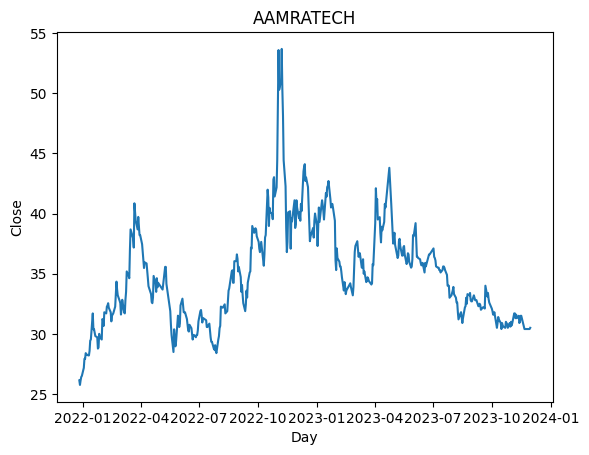

In [5]:
# Changing datatype of Date column in DateTime Format
df["Date"] = pd.to_datetime(df["Date"])

# Indexing our data for matching the original paper
df = df[(df["Date"] >= "2021-12-26") & (df["Date"] <= "2023-11-30")]

# Visualizing the time-series data
plt.plot(df["Date"], df["Close"])
plt.xlabel('Day')
plt.ylabel('Close')
plt.title(f"AAMRATECH")
plt.show();

In [6]:
# prepare dataframe for creating input vectors for LSTM
def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)

  df.set_index("Date", inplace=True)

  for i in range(1, n_steps+1):
    df[f"Close(t-{i})"] = df["Close"].shift(i)

  df.dropna(inplace=True)

  return df

TIMESTEP = 7
shifted_df = prepare_dataframe_for_lstm(df, TIMESTEP)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2022-01-04,27.924528,27.924528,27.169811,26.509434,26.415094,26.132075,25.754717,26.132075
2022-01-05,28.396226,27.924528,27.924528,27.169811,26.509434,26.415094,26.132075,25.754717
2022-01-06,28.301887,28.396226,27.924528,27.924528,27.169811,26.509434,26.415094,26.132075
2022-01-09,28.207547,28.301887,28.396226,27.924528,27.924528,27.169811,26.509434,26.415094
2022-01-10,28.207547,28.207547,28.301887,28.396226,27.924528,27.924528,27.169811,26.509434
...,...,...,...,...,...,...,...,...
2023-11-26,30.400000,30.400000,30.400000,30.400000,30.600000,31.500000,31.500000,31.000000
2023-11-27,30.400000,30.400000,30.400000,30.400000,30.400000,30.600000,31.500000,31.500000
2023-11-28,30.400000,30.400000,30.400000,30.400000,30.400000,30.400000,30.600000,31.500000


In [7]:
# Converting dataframe to numpy array
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[27.9245283 , 27.9245283 , 27.16981132, ..., 26.13207547,
        25.75471698, 26.13207547],
       [28.39622642, 27.9245283 , 27.9245283 , ..., 26.41509434,
        26.13207547, 25.75471698],
       [28.30188679, 28.39622642, 27.9245283 , ..., 26.50943396,
        26.41509434, 26.13207547],
       ...,
       [30.4       , 30.4       , 30.4       , ..., 30.4       ,
        30.6       , 31.5       ],
       [30.4       , 30.4       , 30.4       , ..., 30.4       ,
        30.4       , 30.6       ],
       [30.5       , 30.4       , 30.4       , ..., 30.4       ,
        30.4       , 30.4       ]])

In [8]:
# Scaling our data to be between -1 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -0.97297297],
       [-0.96336996, -1.        , -0.9430605 , ..., -0.97945205,
        -0.97297297, -1.        ],
       [-0.97069597, -0.96336996, -0.9430605 , ..., -0.97260274,
        -0.9527027 , -0.97297297],
       ...,
       [-0.80776557, -0.80776557, -0.75629893, ..., -0.69013699,
        -0.65297297, -0.58851351],
       [-0.80776557, -0.80776557, -0.75629893, ..., -0.69013699,
        -0.6672973 , -0.65297297],
       [-0.8       , -0.80776557, -0.75629893, ..., -0.69013699,
        -0.6672973 , -0.6672973 ]])

In [9]:
# Taking our input and output
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((465, 7), (465,))

In [10]:
# Flipping the X array to match proper sequence of input for LSTM
X = dc(np.flip(X, axis=1))
X

array([[-0.97297297, -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -0.97297297, -0.97945205, ..., -0.95138889,
        -0.9430605 , -1.        ],
       [-0.97297297, -0.9527027 , -0.97260274, ..., -0.89583333,
        -0.9430605 , -0.96336996],
       ...,
       [-0.58851351, -0.65297297, -0.69013699, ..., -0.71361111,
        -0.75629893, -0.80776557],
       [-0.65297297, -0.6672973 , -0.69013699, ..., -0.71361111,
        -0.75629893, -0.80776557],
       [-0.6672973 , -0.6672973 , -0.69013699, ..., -0.71361111,
        -0.75629893, -0.80776557]])

In [11]:
# Splitting data into train and test
split_index = int(len(X) * 0.90)

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((418, 7), (47, 7), (418,), (47,))

In [12]:
# Fixing the dimensions as required for LSTM
X_train = X_train.reshape((-1, 7, 1))
X_test = X_test.reshape((-1, 7, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((418, 7, 1), (47, 7, 1), (418, 1), (47, 1))

In [13]:
# Converting numpy array into PyTorch tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([418, 7, 1]),
 torch.Size([47, 7, 1]),
 torch.Size([418, 1]),
 torch.Size([47, 1]))

# 3. Creating PyTorch Dataset and Dataloader

In [14]:
# Subclassing from the Dataset class to get out train and test datasets
from torch.utils.data import Dataset

class TimeSeriesData(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesData(X_train, y_train)
test_dataset = TimeSeriesData(X_test, y_test)

In [15]:
# Creating dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
for _, (X, y) in enumerate(train_dataloader):
  print(X.shape, y.shape)
  break

torch.Size([16, 7, 1]) torch.Size([16, 1])


# 4. Creating our LSTM Model

In [17]:
# Creating our LSTM model
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1, 5, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

# 5. Predicting Closing Price for AAMRATECH

In [18]:
# Setting up our loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [19]:
# Creating train step
def train_step(model, dataloader, loss_fn, optimizer, epoch, print_every=40, device=device):
  """trains model for one epoch"""
  model.train()
  train_loss = 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(dataloader)

  if (epoch + 1) % print_every == 0:
    print(f"Epoch {epoch + 1}, train_loss: {train_loss:.5f}")

In [20]:
# Creating test step
def test_step(model, dataloader, loss_fn, epoch, print_every=40, device=device):
  """tests model for one epoch"""
  model.eval()
  test_loss = 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_logit = model(X)
      loss = loss_fn(y_logit, y)
      test_loss += loss.item()

  test_loss = test_loss / len(dataloader)

  if (epoch + 1) % print_every == 0:
    print(f"Epoch {epoch + 1}, test_loss: {test_loss:.5f}\n-------------------------------")

In [21]:
# Traing our model
epochs = 200

for epoch in range(epochs):
  train_step(model, train_dataloader, loss_fn, optimizer, epoch=epoch)
  test_step(model, test_dataloader, loss_fn, epoch=epoch)

Epoch 40, train_loss: 0.08743
Epoch 40, test_loss: 0.03106
-------------------------------
Epoch 80, train_loss: 0.07231
Epoch 80, test_loss: 0.02640
-------------------------------
Epoch 120, train_loss: 0.06343
Epoch 120, test_loss: 0.02309
-------------------------------
Epoch 160, train_loss: 0.05971
Epoch 160, test_loss: 0.02432
-------------------------------
Epoch 200, train_loss: 0.05889
Epoch 200, test_loss: 0.02473
-------------------------------


In [22]:
# Getting the unscaled values of the predictions on test set
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], TIMESTEP+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([33.69074898, 33.22634032, 33.4010133 , 33.00426344, 32.68620898,
       32.22304759, 31.9812746 , 31.70538936, 31.65644574, 31.8052254 ,
       31.06733164, 30.71620881, 30.93580727, 31.35324338, 31.28823417,
       31.05652376, 30.6420243 , 30.92588976, 30.82612356, 30.73790746,
       30.64818235, 31.00007964, 30.91935176, 30.68598651, 30.93606133,
       30.75838263, 31.02442634, 30.85015095, 30.96959024, 31.59949274,
       31.72542549, 31.4459274 , 31.6237266 , 31.42009395, 31.53544449,
       31.09613627, 31.09221485, 31.4666904 , 31.54023708, 30.87687552,
       30.60892138, 30.54773764, 30.53059364, 30.52785425, 30.53003793,
       30.53253093, 30.53297765])

In [23]:
# Getting the unscaled values of the outputs of the test set
dummies = np.zeros((X_test.shape[0], TIMESTEP+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([33.1       , 33.40000013, 32.90000016, 32.60000003, 32.10000006,
       31.90000022, 31.60000009, 31.60000009, 31.79999992, 30.79999998,
       30.49999984, 30.90000028, 31.40000025, 31.19999965, 30.90000028,
       30.40000031, 30.90000028, 30.69999968, 30.60000015, 30.49999984,
       30.99999981, 30.79999998, 30.49999984, 30.90000028, 30.60000015,
       30.99999981, 30.69999968, 30.90000028, 31.69999962, 31.69999962,
       31.29999995, 31.60000009, 31.29999995, 31.49999978, 30.90000028,
       30.99999981, 31.49999978, 31.49999978, 30.60000015, 30.40000031,
       30.40000031, 30.40000031, 30.40000031, 30.40000031, 30.40000031,
       30.40000031, 30.49999984])

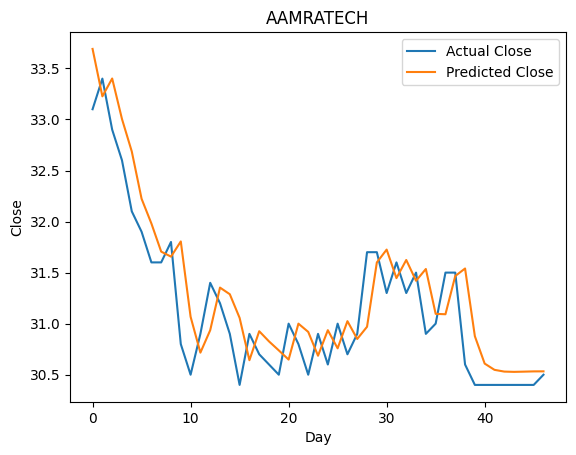

In [24]:
# Plotting the Results of test set
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title("AAMRATECH")
plt.show()

# 6. Functionizing the training process

In [25]:
def lstm_time_series(df, company_name=None):
  print(f"FOR {company_name}")
  print("--------------------------")
  print("--------------------------")
  df = df[["Date", "Close"]]
  df["Date"] = pd.to_datetime(df["Date"])
  df = df[(df["Date"] >= "2021-12-26") & (df["Date"] <= "2023-11-30")]

  plt.plot(df["Date"], df["Close"])
  plt.xlabel('Day')
  plt.ylabel('Close')
  plt.title(f"{company_name}")
  plt.show()

  shifted_df = prepare_dataframe_for_lstm(df, 7)
  shifted_df_as_np = shifted_df.to_numpy()

  scaler = MinMaxScaler(feature_range=(-1, 1))
  shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

  X = shifted_df_as_np[:, 1:]
  y = shifted_df_as_np[:, 0]

  X = dc(np.flip(X, axis=1))

  split_index = int(len(X) * 0.90)
  X_train = X[:split_index]
  X_test = X[split_index:]

  y_train = y[:split_index]
  y_test = y[split_index:]

  X_train = X_train.reshape((-1, 7, 1))
  X_test = X_test.reshape((-1, 7, 1))

  y_train = y_train.reshape((-1, 1))
  y_test = y_test.reshape((-1, 1))

  X_train = torch.tensor(X_train).float()
  X_test = torch.tensor(X_test).float()
  y_train = torch.tensor(y_train).float()
  y_test = torch.tensor(y_test).float()

  train_dataset = TimeSeriesData(X_train, y_train)
  test_dataset = TimeSeriesData(X_test, y_test)

  batch_size = 16

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
  test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

  epochs = 200

  for epoch in range(epochs):
    train_step(model, train_dataloader, loss_fn, optimizer, epoch=epoch)
    test_step(model, test_dataloader, loss_fn, epoch=epoch)

  test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

  dummies = np.zeros((X_test.shape[0], 7+1))
  dummies[:, 0] = test_predictions
  dummies = scaler.inverse_transform(dummies)

  test_predictions = dc(dummies[:, 0])
  test_predictions

  dummies = np.zeros((X_test.shape[0], 7+1))
  dummies[:, 0] = y_test.flatten()
  dummies = scaler.inverse_transform(dummies)

  new_y_test = dc(dummies[:, 0])
  new_y_test

  plt.plot(new_y_test, label='Actual Close')
  plt.plot(test_predictions, label='Predicted Close')
  plt.xlabel('Day')
  plt.ylabel('Close')
  if company_name:
    plt.title(f"{company_name}")
  plt.legend()
  plt.show()

# 7. ADVENT

FOR ADVENT
--------------------------
--------------------------


<ipython-input-25-3db34a9f9178>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


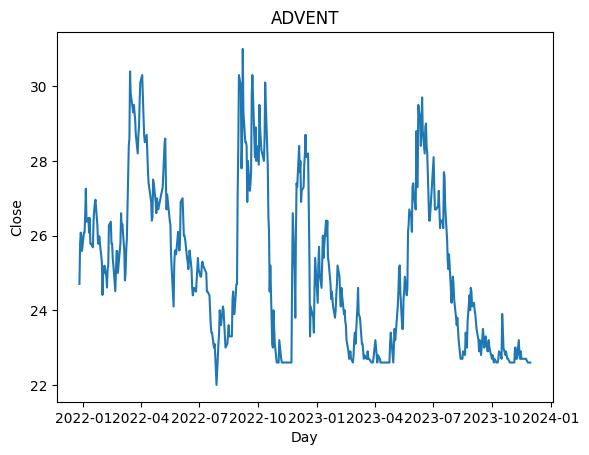

Epoch 40, train_loss: 0.10370
Epoch 40, test_loss: 0.03259
-------------------------------
Epoch 80, train_loss: 0.10148
Epoch 80, test_loss: 0.03188
-------------------------------
Epoch 120, train_loss: 0.10032
Epoch 120, test_loss: 0.03144
-------------------------------
Epoch 160, train_loss: 0.10071
Epoch 160, test_loss: 0.03331
-------------------------------
Epoch 200, train_loss: 0.10046
Epoch 200, test_loss: 0.03219
-------------------------------


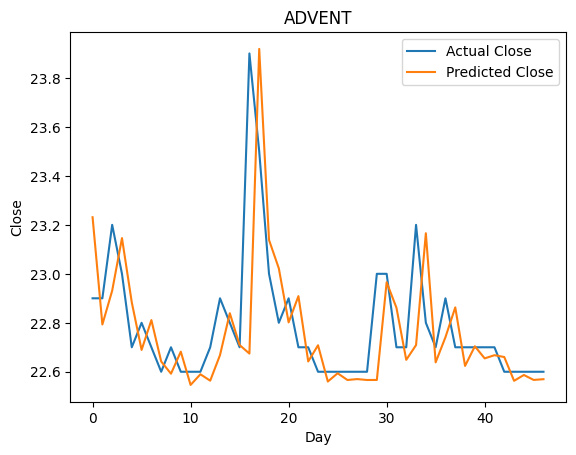

In [26]:
df_advent = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/ADVENT_data.csv")
lstm_time_series(df_advent, "ADVENT")

# 8. AGRODENIM

FOR AGRODENIM
--------------------------
--------------------------


<ipython-input-25-3db34a9f9178>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


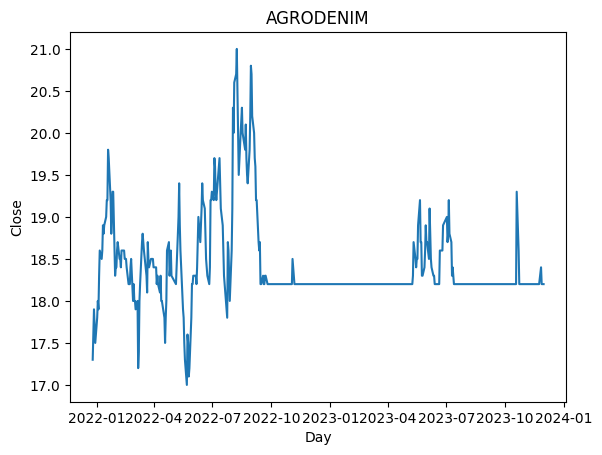

Epoch 40, train_loss: 0.07389
Epoch 40, test_loss: 0.03599
-------------------------------
Epoch 80, train_loss: 0.07323
Epoch 80, test_loss: 0.03544
-------------------------------
Epoch 120, train_loss: 0.07289
Epoch 120, test_loss: 0.03544
-------------------------------
Epoch 160, train_loss: 0.07264
Epoch 160, test_loss: 0.03572
-------------------------------
Epoch 200, train_loss: 0.07251
Epoch 200, test_loss: 0.03616
-------------------------------


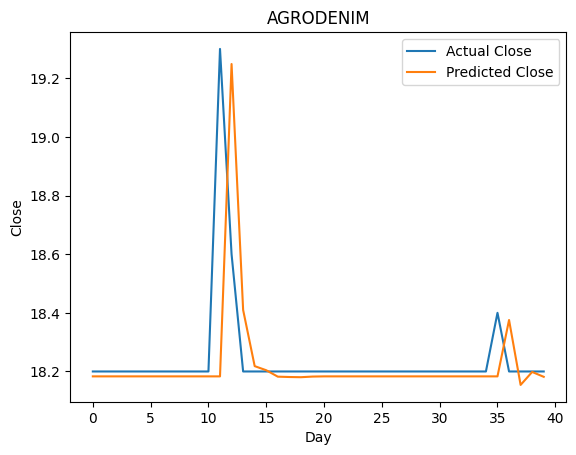

In [27]:
df_agrodenim = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/ARGONDENIM_data.csv")
lstm_time_series(df_agrodenim, "AGRODENIM")

# 9. BDTHAIFOOD

FOR BDTHAIFOOD
--------------------------
--------------------------


<ipython-input-25-3db34a9f9178>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


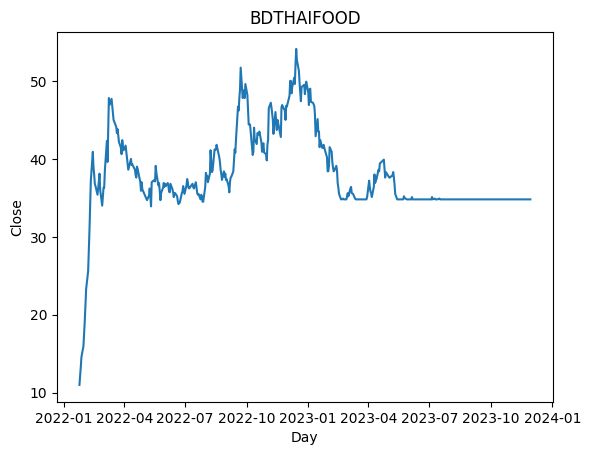

Epoch 40, train_loss: 0.04578
Epoch 40, test_loss: 0.00099
-------------------------------
Epoch 80, train_loss: 0.04574
Epoch 80, test_loss: 0.00006
-------------------------------
Epoch 120, train_loss: 0.04587
Epoch 120, test_loss: 0.00375
-------------------------------
Epoch 160, train_loss: 0.04559
Epoch 160, test_loss: 0.00018
-------------------------------
Epoch 200, train_loss: 0.04537
Epoch 200, test_loss: 0.00176
-------------------------------


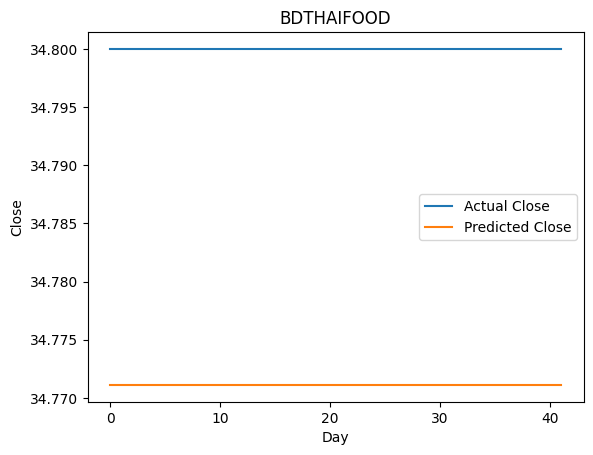

In [28]:
df_bdthaifood = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/BDTHAIFOOD_data.csv")
lstm_time_series(df_bdthaifood, "BDTHAIFOOD")

# 10. ECABLES

FOR ECABLES
--------------------------
--------------------------


<ipython-input-25-3db34a9f9178>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


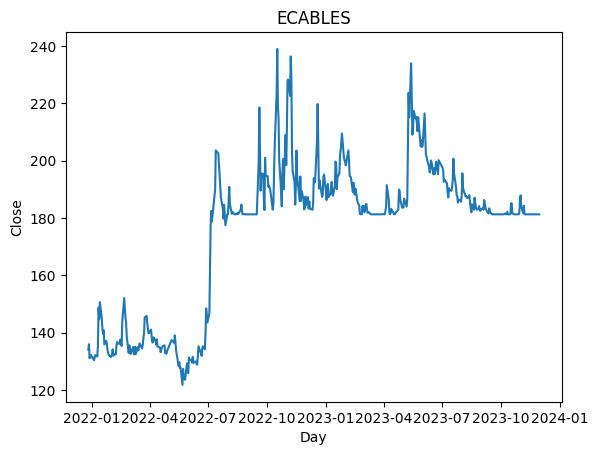

Epoch 40, train_loss: 0.05384
Epoch 40, test_loss: 0.01059
-------------------------------
Epoch 80, train_loss: 0.05454
Epoch 80, test_loss: 0.01419
-------------------------------
Epoch 120, train_loss: 0.05387
Epoch 120, test_loss: 0.01042
-------------------------------
Epoch 160, train_loss: 0.05463
Epoch 160, test_loss: 0.01125
-------------------------------
Epoch 200, train_loss: 0.05405
Epoch 200, test_loss: 0.01013
-------------------------------


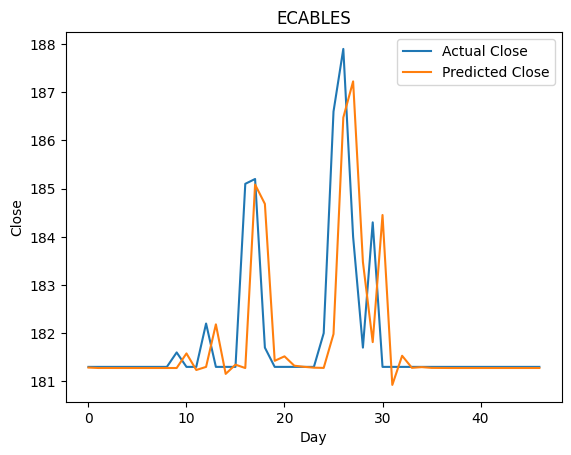

In [29]:
df_ecables = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/ECABLES_data.csv")
lstm_time_series(df_ecables, "ECABLES")

# 11. KEYACOSMET

FOR KEYACOSMET
--------------------------
--------------------------


<ipython-input-25-3db34a9f9178>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


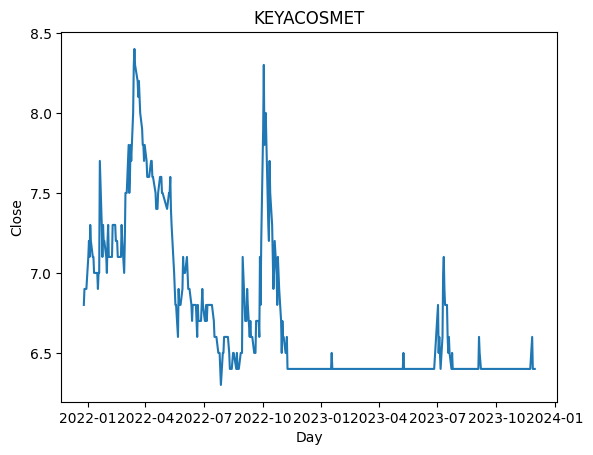

Epoch 40, train_loss: 0.06316
Epoch 40, test_loss: 0.01747
-------------------------------
Epoch 80, train_loss: 0.05997
Epoch 80, test_loss: 0.01006
-------------------------------
Epoch 120, train_loss: 0.05862
Epoch 120, test_loss: 0.00940
-------------------------------
Epoch 160, train_loss: 0.05863
Epoch 160, test_loss: 0.01000
-------------------------------
Epoch 200, train_loss: 0.05859
Epoch 200, test_loss: 0.00997
-------------------------------


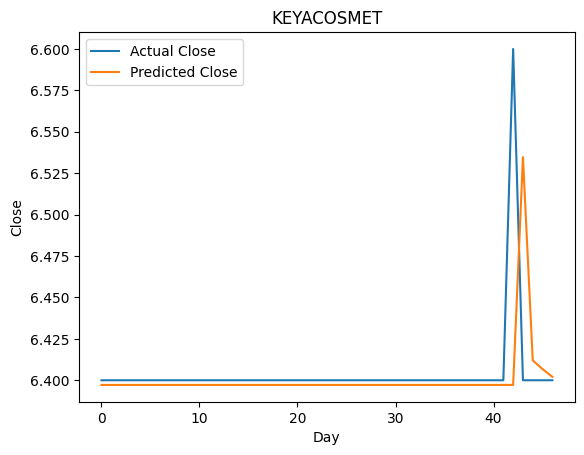

In [30]:
df_keyacosmet = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/KEYACOSMET_data.csv")
lstm_time_series(df_keyacosmet, "KEYACOSMET")

# 12. MEGHNAPET

FOR MEGHNAPET
--------------------------
--------------------------


<ipython-input-25-3db34a9f9178>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


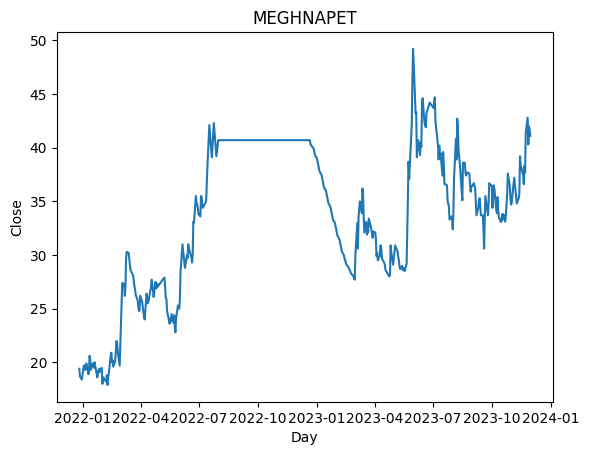

Epoch 40, train_loss: 0.04701
Epoch 40, test_loss: 0.06583
-------------------------------
Epoch 80, train_loss: 0.04673
Epoch 80, test_loss: 0.06563
-------------------------------
Epoch 120, train_loss: 0.04774
Epoch 120, test_loss: 0.06722
-------------------------------
Epoch 160, train_loss: 0.04616
Epoch 160, test_loss: 0.06678
-------------------------------
Epoch 200, train_loss: 0.04610
Epoch 200, test_loss: 0.06561
-------------------------------


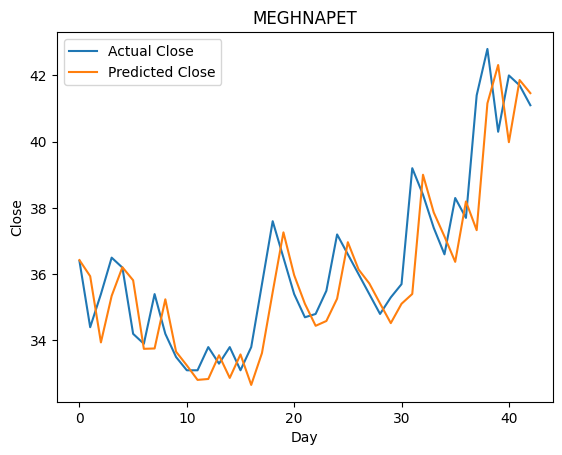

In [31]:
df_meghnapet = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/MEGHNAPET_data.csv")
lstm_time_series(df_meghnapet, "MEGHNAPET")

# 13. PRIMETEX

FOR PRIMETEX
--------------------------
--------------------------


<ipython-input-25-3db34a9f9178>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


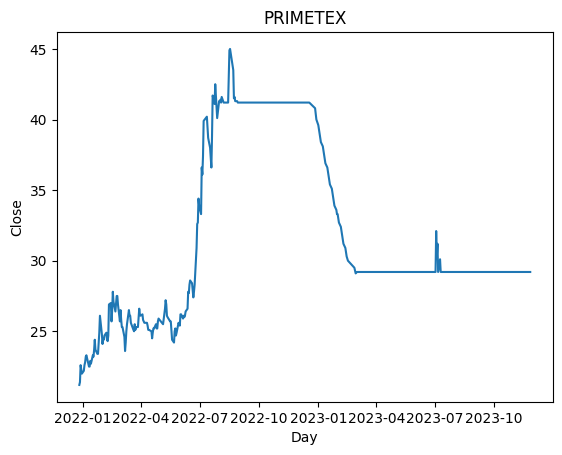

Epoch 40, train_loss: 0.03072
Epoch 40, test_loss: 0.00235
-------------------------------
Epoch 80, train_loss: 0.03079
Epoch 80, test_loss: 0.00302
-------------------------------
Epoch 120, train_loss: 0.03028
Epoch 120, test_loss: 0.00614
-------------------------------
Epoch 160, train_loss: 0.03364
Epoch 160, test_loss: 0.00193
-------------------------------
Epoch 200, train_loss: 0.03653
Epoch 200, test_loss: 0.00320
-------------------------------


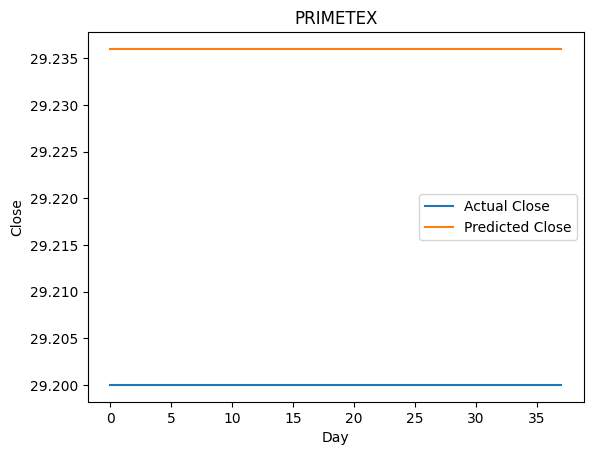

In [32]:
df_primetex = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/PRIMETEX_data.csv")
lstm_time_series(df_primetex, "PRIMETEX")

# 14. PUBALIBANK

FOR PUBALIBANK
--------------------------
--------------------------


<ipython-input-25-3db34a9f9178>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


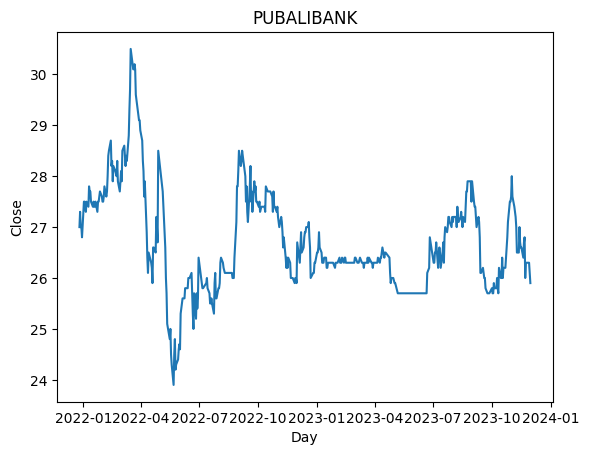

Epoch 40, train_loss: 0.05382
Epoch 40, test_loss: 0.05923
-------------------------------
Epoch 80, train_loss: 0.05368
Epoch 80, test_loss: 0.05912
-------------------------------
Epoch 120, train_loss: 0.05467
Epoch 120, test_loss: 0.06281
-------------------------------
Epoch 160, train_loss: 0.05285
Epoch 160, test_loss: 0.05813
-------------------------------
Epoch 200, train_loss: 0.05289
Epoch 200, test_loss: 0.05827
-------------------------------


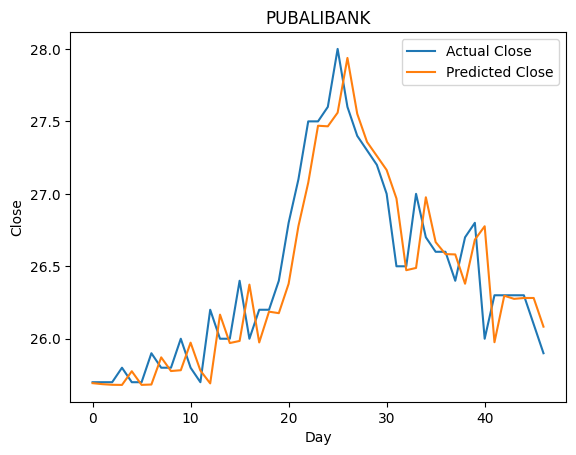

In [33]:
df_pubalibank = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/PUBALIBANK_data.csv")
lstm_time_series(df_pubalibank, "PUBALIBANK")

# 15. UNIONCAP

FOR UNIONCAP
--------------------------
--------------------------


<ipython-input-25-3db34a9f9178>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


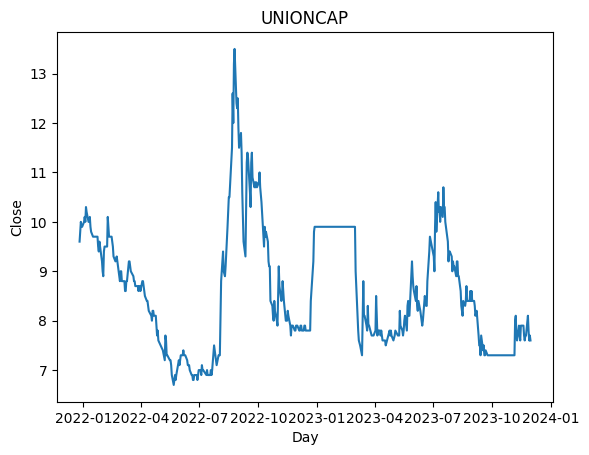

Epoch 40, train_loss: 0.05637
Epoch 40, test_loss: 0.02652
-------------------------------
Epoch 80, train_loss: 0.05662
Epoch 80, test_loss: 0.02664
-------------------------------
Epoch 120, train_loss: 0.05620
Epoch 120, test_loss: 0.02584
-------------------------------
Epoch 160, train_loss: 0.05659
Epoch 160, test_loss: 0.02804
-------------------------------
Epoch 200, train_loss: 0.05624
Epoch 200, test_loss: 0.02599
-------------------------------


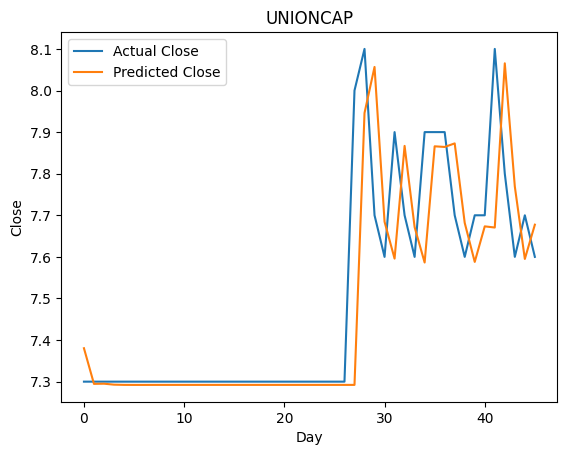

In [34]:
df_unioncap = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/UNIONCAP_data.csv")
lstm_time_series(df_unioncap, "UNIONCAP")